In [2]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

master_hvcs = hvcl.load_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24])

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete


# KS Testing

## Split the RMs into two populations

In [69]:
#master_hvcs[0]["RMs"]
master_hvcs[4]["HVC"]

Name,SkyCoord,RAJ2000,DEJ2000,VLSR,e_VLSR,VGSR,Vdev,FWHM,TbFit,NH,e_NH,Area,dx,dy,Flag,HI,WW91,Simbad,recno,Cat,Nearest RM
,"deg,deg",,,km / s,km / s,km / s,km / s,km / s,K,1 / cm2,1 / cm2,deg2,deg,deg,,,,,,,deg
str15,SkyCoord,str11,str9,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str4,str19,str18,str6,int32,str4,float64
G133.5-75.6-294,"15.548161692114391,-13.005834286896315",01 02 11.56,-13 00 21,-294.1,1.8,-254.6,-261.6,26.8,0.42,2e+19,3e+18,1.3,4.2,1.4,H2,HVC 131.9-75.8-302,"EN,MS_MS",Simbad,427,GHVC,0.048293947366666666


In [28]:
import numpy as np

def split_RMs(RMs, centre, max_distance):
    mask = np.zeros(len(RMs), dtype=bool)
    for i in range(len(RMs)):
        rmi = RMs[i]
        mask[i] = rmi["ra_dec_obj"].separation(centre).value < max_distance

    RMs_inner = RMs[~mask]
    RMs_outer = RMs[mask]

    return RMs_inner, RMs_outer
        

inner, outer = split_RMs(master_hvcs[0]["RMs"], master_hvcs[0]["HVC"]["SkyCoord"], max(master_hvcs[0]["HVC"]["dx"], master_hvcs[0]["HVC"]["dy"]))

#print(len(master_hvcs[0]["RMs"]))
print(len(inner))
print(len(outer))

144
909


## Produce CDFs of distributions

In [50]:
import scipy.stats as stats

def make_cdfs(inner, outer):
    inner_data = np.sort(inner["B_virtual [int]"].data*1e6)
    inner_cdf = stats.norm.cdf(inner_data)

    outer_data = np.sort(outer["B_virtual [int]"].data*1e6)
    outer_cdf = stats.norm.cdf(outer_data)

    return inner_data, inner_cdf, outer_data, outer_cdf

inner_data, inner_cdf, outer_data, outer_cdf = make_cdfs(inner, outer)
#print(inner_cdf)
#print(np.sort(inner["B_virtual [int]"].data*1e6))

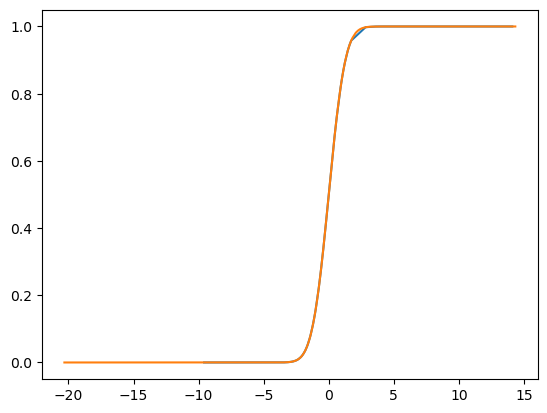

In [51]:
import matplotlib.pyplot as plt

plt.plot(inner_data, inner_cdf)
plt.plot(outer_data, outer_cdf)
plt.show()

## Perform Scipy KS test

Analysing HVC: G133.5-75.6-294


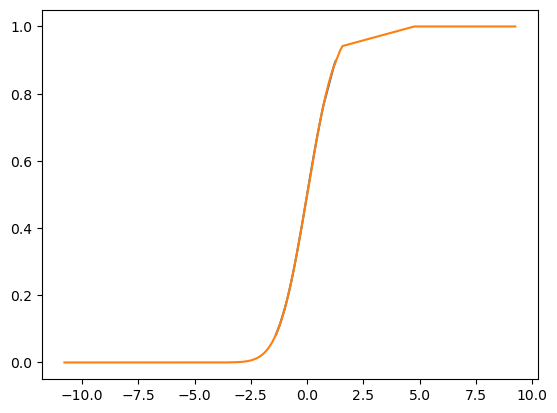

{'Name': 'G133.5-75.6-294',
 'Statistic': 0.46130268199233715,
 'p_value': 4.570648166268751e-08,
 'Statistic_x': -1.0081759072724916,
 'Statistic_sgn': -1,
 'Significant': True}

In [123]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from astropy.table import Table

def column_to_array(data):
    return np.sort(data.data*1e6)

def split_RMs(RMs, centre, max_distance):
    mask = np.zeros(len(RMs), dtype=bool)
    for i in range(len(RMs)):
        rmi = RMs[i]
        mask[i] = rmi["ra_dec_obj"].separation(centre).value < max_distance

    RMs_inner = RMs[~mask]
    RMs_outer = RMs[mask]

    return RMs_inner, RMs_outer

def morph_ring(hvc_snap):
    return (hvc_snap["HVC"]["dx"] + hvc_snap["HVC"]["dy"])/2

def make_cdfs(inner, outer):
    inner_data = inner
    inner_cdf = stats.norm.cdf(inner_data)

    outer_data = outer
    outer_cdf = stats.norm.cdf(outer_data)

    return inner_data, inner_cdf, outer_data, outer_cdf

def KStest_single(snapshots, index = 0, show = False, dict_answer=True, p_value=0.05):
    hvc_snap = snapshots[index]
    inner_rms, outer_rms = split_RMs(hvc_snap["RMs"],hvc_snap["HVC"]["SkyCoord"], morph_ring(hvc_snap))
    inner = column_to_array(inner_rms["B_virtual [int]"])
    outer = column_to_array(outer_rms["B_virtual [int]"])

    print("Analysing HVC: " + hvc_snap["HVC"]["Name"])
    #print(len(outer), len(inner))
    #print(morph_ring(hvc_snap))

    if show:
        inner_data, inner_cdf, outer_data, outer_cdf = make_cdfs(inner, outer)

        plt.plot(inner_data, inner_cdf)
        plt.plot(outer_data, outer_cdf)
        plt.show()

    ks_test = stats.ks_2samp(inner, outer)#, nan_policy='omit')

    if not dict_answer:
        return ks_test
    else:
        return {"Name":hvc_snap["HVC"]["Name"], "Statistic":ks_test.statistic, "p_value":ks_test.pvalue, "Statistic_x":ks_test.statistic_location, "Statistic_sgn":ks_test.statistic_sign, "Significant": ks_test.pvalue < p_value}
        
KStest_single(master_hvcs, show=True, index=4)

In [124]:
def KStest_hvcs(snapshots, show=False, dict_answer=True, p_value=0.05):
    KSlist = []
    for i in range(len(snapshots)):
        KSlist.append(KStest_single(snapshots, index=i, show=show, dict_answer=dict_answer, p_value=p_value))
    return KSlist

KSlist = KStest_hvcs(master_hvcs)

Analysing HVC: G038.7-37.3-241
Analysing HVC: G038.8-33.2-261
Analysing HVC: G043.4-30.4-230
Analysing HVC: G089.0-64.7-311
Analysing HVC: G133.5-75.6-294
Analysing HVC: G248.9+36.8+181
Analysing HVC: G261.5-34.5+237
Analysing HVC: G262.4-26.2+143
Analysing HVC: G264.6-53.3+224
Analysing HVC: G267.1-38.4+263
Analysing HVC: G271.6-48.4+297
Analysing HVC: G271.7-53.1+254
Analysing HVC: G282.3-38.3+117
Analysing HVC: G298.0-81.7+127
Analysing HVC: G323.0+25.6+122


In [125]:
Table(rows=KSlist)#, names=("statistic", "pvalue", "statistic_location", "statistic_sign"))

Name,Statistic,p_value,Statistic_x,Statistic_sgn,Significant
str15,float64,float64,float64,int32,bool
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,True
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,True
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,True
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,True
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,True
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,False
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,True
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,True
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,True


# Putting it all together

In [1]:
import sys
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/standard_modules')
sys.path.append('C://Users/olive/OneDrive - Australian National University/Honours-Olivia/Programs/honours/project')

from collation import collator, hvc_snapshot as snap
from synthesis import hvc_looper as hvcl, magnetic_field_derivation as mfd

collated_data = collator.data_whole_sky(False, load_data=["../data_processed/proc_rms","../data_processed/proc_hvcs"], h1_img="../data_catalog/hi4pi-hvc-nhi-car.fits", override_RMs=True)

KStable = hvcl.KStest_HVCs(collated_data, hvc_indicies=[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13, 16, 22, 24], morph_type="minimum", save_file="../data_processed/hvc_KS_tests/hvc_KS")

KStable

=== WHOLE-SKY DATA COLLATION ===
Gathering data ...
Getting H-alpha emission
Extracting RMs
Getting HVC location data
Getting HI emission
Interpolating
Collation complete
=== HVC RM LOADER ===
Taking HVC snapshots
Process complete
=== HVC KS TESTING ===
Performing KS Tests
Converting
Saving data
Process Complete


Name,Statistic,p_value,Statistic_x,Statistic_sgn,Significant
str15,float64,float64,float64,int32,bool
G038.7-37.3-241,0.2074738871132492,3.5194997048780594e-09,-3.515687526708854,-1,True
G038.8-33.2-261,0.31066825775656326,1.3943532792837091e-08,-0.6963302660734451,-1,True
G043.4-30.4-230,0.24109469074986317,3.606854288675973e-11,-1.2589038059025925,-1,True
G089.0-64.7-311,0.3738140417457306,0.015075834341180974,-3.5031459148744912,1,True
G133.5-75.6-294,0.46130268199233715,4.570648166268751e-08,-1.0081759072724916,-1,True
G248.9+36.8+181,0.08070447918650822,0.452664079053446,-2.5040967925547646,-1,False
G261.5-34.5+237,0.2889454915944982,5.960798790546759e-08,-5.487954609053061,-1,True
G262.4-26.2+143,0.21329644533869885,1.2224926075128765e-06,2.0255699650566523,-1,True
G264.6-53.3+224,0.3195887445887446,4.0730287570954555e-05,0.9062634882158793,1,True
